In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
interval_var = '5min'
symbol='BTC'

In [3]:
df = pd.read_csv('BTC_USD_210101_220101.csv')

In [4]:
# 2021.01.01 - 21.03.31
df = df[25920 * 3 : 25920 * 4]
df = df.reset_index()
print(df)

        index    <DATE>  <TIME>    <OPEN>    <HIGH>     <LOW>   <CLOSE>  <VOL>
0       77760  20210928    1000  42767.45  42781.60  42704.58  42767.99     25
1       77761  20210928    1500  42770.70  42820.90  42747.30  42799.10     18
2       77762  20210928    2000  42800.82  42801.32  42753.85  42755.88     15
3       77763  20210928    2500  42758.21  42873.86  42750.00  42861.75     21
4       77764  20210928    3000  42861.76  42935.99  42836.63  42860.35     53
...       ...       ...     ...       ...       ...       ...       ...    ...
25915  103675  20211227   13000  50917.11  50925.95  50857.28  50869.20     22
25916  103676  20211227   13500  50869.20  51046.50  50869.19  51012.72     34
25917  103677  20211227   14000  51011.66  51295.33  51006.63  51226.50     65
25918  103678  20211227   14500  51226.48  51236.73  51080.89  51138.44     38
25919  103679  20211227   15000  51138.43  51145.07  50950.00  51034.57     43

[25920 rows x 8 columns]


In [5]:
df=df.drop(['index', '<TIME>'], axis=1)


In [6]:
def AddSlopes(df, n):    
    slopes_array = [0]*(n-1)
    x = np.array(range(n))
    x_sc = (x - x.min())/(x.max() - x.min())
    x_sc = sm.add_constant(x_sc)
    for j in range(n, len(df) + 1):
        y = df['close'][j-n:j]
        y_sc = (y - y.min())/(y.max() - y.min())
        model = sm.OLS(y_sc,x_sc)
        results = model.fit()
        slopes_array.append(results.params[-1])
    slopes_array = np.rad2deg(np.arctan(np.array(slopes_array)))
    df['slope'] = slopes_array

In [7]:
def AddChannel(df, lenght):
    df['channel_max'] = df['high'].rolling(lenght).max()
    df['channel_min'] = df['low'].rolling(lenght).min()
    df['position_in_channel'] = (df['close'] - df['channel_min']) / (df['channel_max'] - df['channel_min'])

In [8]:
# LMin - local minimum
def islmin(DF, i):
    ans = False
    if DF['close'][i]<=DF['close'][i+1] and DF['close'][i]<=DF['close'][i-1] and DF['close'][i+1]>DF['close'][i-1]:
        ans = True;
    return ans

# LMAX - local maximum
def islmax(DF, i):
    ans = False
    if DF['close'][i]>=DF['close'][i+1] and DF['close'][i]>=DF['close'][i-1] and DF['close'][i+1]<DF['close'][i-1]:
        ans = True;
    return ans

In [9]:
def AddLMaxMin(df):
    df['islmin'] = [None] * len(df)
    df['islmax'] = [None] * len(df)
    for i in range(4, len(df) - 1):
        df.at[i, 'islmin'] = islmin(df, i)
        df.at[i, 'islmax'] = islmax(df, i)

In [10]:
def PrepareDF(df):
    df.columns = ["date","open","high","low","close","volume"]
     
    df.reset_index()
    AddSlopes(df, 5)
    AddChannel(df, 14)
    AddLMaxMin(df)


In [11]:
PrepareDF(df)
prepared_df = df
print(prepared_df)

           date      open      high       low     close  volume      slope  \
0      20210928  42767.45  42781.60  42704.58  42767.99      25   0.000000   
1      20210928  42770.70  42820.90  42747.30  42799.10      18   0.000000   
2      20210928  42800.82  42801.32  42753.85  42755.88      15   0.000000   
3      20210928  42758.21  42873.86  42750.00  42861.75      21   0.000000   
4      20210928  42861.76  42935.99  42836.63  42860.35      53  43.064377   
...         ...       ...       ...       ...       ...     ...        ...   
25915  20211227  50917.11  50925.95  50857.28  50869.20      22   5.362199   
25916  20211227  50869.20  51046.50  50869.19  51012.72      34  35.036356   
25917  20211227  51011.66  51295.33  51006.63  51226.50      65  41.767722   
25918  20211227  51226.48  51236.73  51080.89  51138.44      38  41.784395   
25919  20211227  51138.43  51145.07  50950.00  51034.57      43  27.067503   

       channel_max  channel_min  position_in_channel islmin isl

## Some plots

<AxesSubplot:>

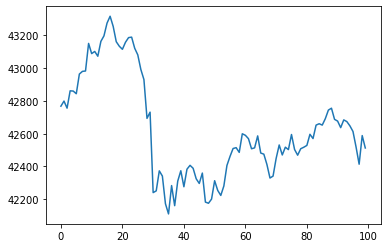

In [12]:
prepared_df[:100]['close'].plot()

<AxesSubplot:>

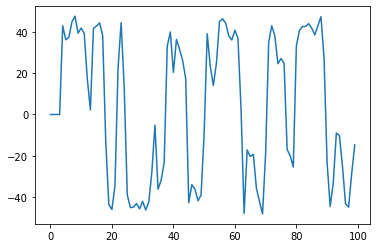

In [13]:
prepared_df[:100]['slope'].plot()

<AxesSubplot:>

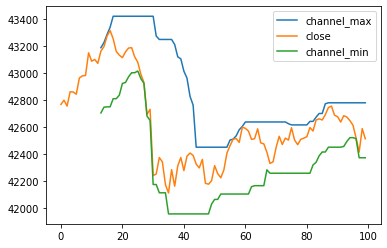

In [14]:
prepared_df[:100][{'channel_max', 'channel_min', 'close'}].plot()

<AxesSubplot:>

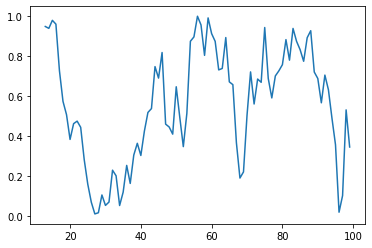

In [15]:
prepared_df[:100]['position_in_channel'].plot()

## Some plots

    index      date      open      high       low     close  volume  \
0     100  20210928  42514.30  42547.44  42453.03  42459.58      14   
1     101  20210928  42459.18  42554.77  42425.37  42523.91      21   
2     102  20210928  42523.90  42537.96  42428.51  42448.81      12   
3     103  20210928  42452.31  42551.94  42448.81  42547.96       8   
4     104  20210928  42550.77  42550.77  42388.49  42432.89      23   
..    ...       ...       ...       ...       ...       ...     ...   
95    195  20210928  42087.88  42281.17  42055.69  42215.74      55   
96    196  20210928  42213.79  42496.61  42137.92  42394.21      73   
97    197  20210928  42392.69  42510.23  42258.63  42301.98     172   
98    198  20210928  42300.01  42384.01  42198.97  42368.41      39   
99    199  20210928  42372.53  42423.66  42301.34  42323.98      35   

        slope  channel_max  channel_min  position_in_channel islmin islmax  
0   -2.468936     42780.00     42371.44             0.215733   True  F

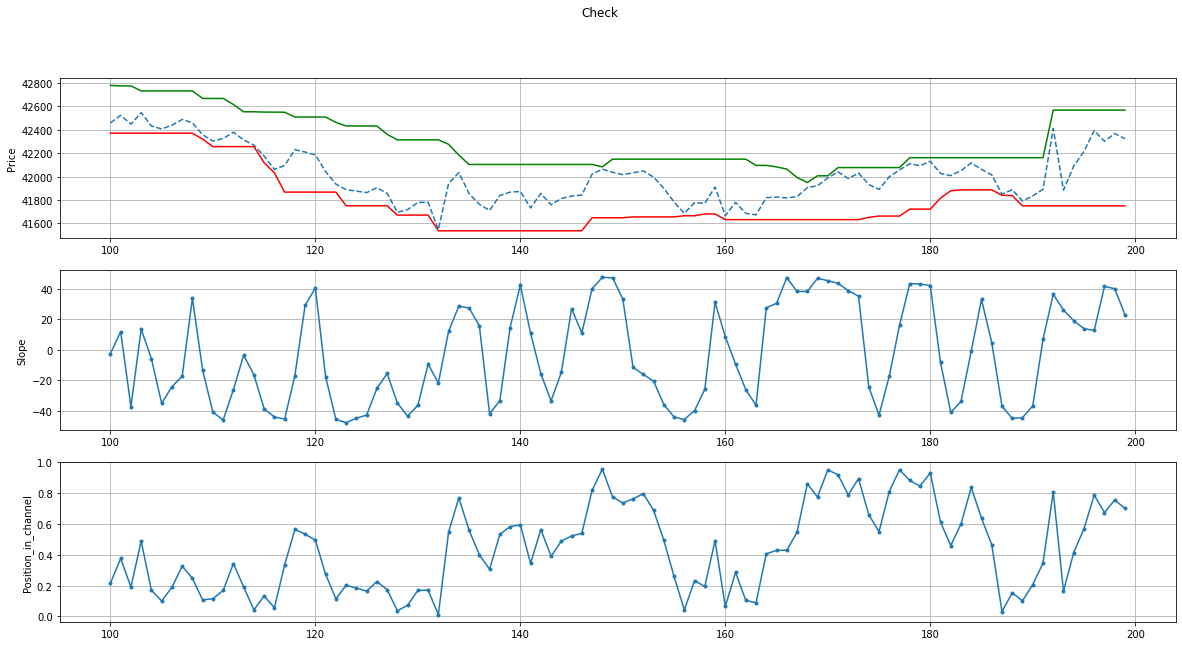

In [16]:
small_df = prepared_df[100:200]
small_df = small_df.reset_index()
print(small_df)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1)
fig.suptitle('Check')
fig.set_size_inches(20, 10)
x = small_df['index']

labels = {"close" : "--", "channel_max" : "g-", "channel_min" : "r-"}
for label in labels:
    ax1.plot(x, small_df[label], labels[label])

ax1.set_ylabel('Price')
ax1.grid(True)

ax2.plot(x, small_df['slope'], '.-')
ax2.set_ylabel('Slope')
ax2.grid(True)

ax3.plot(x, small_df['position_in_channel'], '.-')
ax3.set_ylabel("Position_in_channel")
ax3.grid(True)

plt.show()


# Testing strategy

In [17]:
stop_loss = 0.1
btc_profits_array = [[1, 0.005], [2, 0.01], [2, 0.015], [3, 0.02], [2, 0.025], [0, 0.03]]

def testing_strategy(prepared_df, stop_loss, profit_coefs):
    
    position=0
    total_earn = 0
    df_len = len(prepared_df)

    print('start')

    for i in range(4, df_len-1):
        if position>0:
        # have long
            if(prepared_df['close'][i]<stop_price):
                # stop loss
                print(i, 'long stop loss')
                total_earn -= (open_price - prepared_df['close'][i]) * position
                position = 0
            else:
                # maybe close position 
                while profits_array[current_profit_pos][1] <= prepared_df['close'][i] and position > 0:
                    print(i, 'long earn')
                    position -= profits_array[current_profit_pos][0]
                    total_earn += profits_array[current_profit_pos][0] * (prepared_df['close'][i] - open_price)
                    current_profit_pos += 1

        elif position<0:
        # have hort
            if(prepared_df['close'][i]>stop_price):
                # stop loss
                print(i, 'short stop loss')
                total_earn += (prepared_df['close'][i]-open_price) * position
                position=0
            else:
                # maybe close position
                while profits_array[current_profit_pos][1] >= prepared_df['close'][i] and position < 0:
                    print(i, 'short earn')
                    position += profits_array[current_profit_pos][0]
                    total_earn -= profits_array[current_profit_pos][0] * (prepared_df['close'][i] - open_price)
                    current_profit_pos += 1
        else:
            if(prepared_df['islmin'][i-1]):
                # open long
                if(prepared_df['position_in_channel'][i-1]<0.3 and prepared_df['slope'][i-1])<-10:
                    print(i, 'open long')
                    profits_array=list()
                    current_profit_pos = 0
                    open_price = prepared_df['close'][i]
                    stop_price = prepared_df['close'][i] * (1 - stop_loss)
                    for pr in profit_coefs:
                        profits_array.append([pr[0], (1 + pr[1]) * open_price])
                    position = 10
            if(prepared_df['islmax'][i-1]):
                # open short
                if(prepared_df['position_in_channel'][i-1]>0.7 and (prepared_df['slope'][i-1])>12):
                    print(i, 'open short')
                    profits_array=list()
                    current_profit_pos = 0
                    open_price=prepared_df['close'][i]
                    stop_price=prepared_df['close'][i]*(1 + stop_loss)
                    for pr in profit_coefs:
                        profits_array.append([pr[0], (1 - pr[1]) * open_price])
                    position = -10
    return total_earn

In [31]:
stop_loss = 0.1
btc_profits_array = [[1, 0.005], [2, 0.01], [3, 0.015], [2, 0.02], [2, 0.025], [0, 0.03]]

current_earn = testing_strategy(prepared_df, stop_loss, btc_profits_array)

start
17 open short
26 short earn
28 short earn
30 short earn
30 short earn
34 short earn
36 open long
56 long earn
87 long earn
625 long earn
640 long earn
646 long earn
671 open long
835 long earn
985 long earn
986 long earn
987 long earn
989 long earn
1015 open short
2054 short stop loss
2055 open short
2076 short earn
2497 short stop loss
2531 open short
2644 short earn
2644 short earn
2755 short earn
2821 short earn
5125 short stop loss
5127 open short
5747 short earn
5750 short earn
5757 short earn
6545 short stop loss
6559 open short
6575 short earn
6613 short earn
6616 short earn
6678 short earn
6681 short earn
6693 open short
6696 short earn
6739 short earn
6831 short earn
6832 short earn
6840 short earn
6841 open long
10304 long earn
11847 long earn
11849 long earn
11850 long earn
11855 long earn
11872 open short
12675 short earn
12675 short earn
12675 short earn
12675 short earn
12675 short earn
12703 open long
12717 long earn
12800 long earn
13859 long earn
13860 long earn


In [32]:
print(current_earn)

-25910.019999999844
